In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter

In [154]:
def result_to_df(data, method=None, crop_size=None):
    rows = []
    method = method or data['method'][0] 
    crop_size = crop_size or str(data['crop_size'][0])
    resuts = data['results'][method][crop_size]
    for std, t in resuts.items():
        test = [t[i][0] for i in range(len(t))]
        train = [t[i][2] for i in range(len(t))]
        val = [t[i][1] for i in range(len(t))]
        
        rows.append({'Method': method,
                    'Cropsize': crop_size,
                    'Std': std,
                    'test_mean': np.mean(test),
                    'train_mean': np.mean(train), 
                    'val_mean': np.mean(val), 
                    'test_cer': np.std(test, ddof=1),
                    'train_cer': np.std(train, ddof=1), 
                    'val_cer': np.std(val, ddof=1),
                    })

    # Create DataFrame
    df1 = pd.DataFrame(rows)
    #df['mean'] = df[['t1','t2','t3','t4']].mean(axis=1)
    #df['certainty bound'] = df[['t1','t2','t3']].std(axis=1)
    df1.head(2)
    return df1

# Results Prototype hidden_dim = 128   Not Adaptive

In [155]:
without_pretrain = {"results": {"without_Pretraining": {"0.2": {"0.001": [[0.314, 0.3123, 0.31285], [0.314, 0.3123, 0.31285], [0.314, 0.3123, 0.31285], [0.314, 0.3123, 0.31285]]}}}, "epoch": 0, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625280", "method": ["without_Pretraining"], "crop_size": [0.2], "std": [0.001], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
random_croping ={"results": {"rc": {"0.2": {"0.001": [[0.6319, 0.6466, 0.6648], [0.6358, 0.643, 0.6607], [0.6212, 0.6307, 0.658325], [0.6377, 0.6441, 0.6646]]}, "0.4": {"0.001": [[0.6069, 0.6088, 0.6281], [0.6096, 0.6151, 0.631225], [0.6102, 0.6112, 0.63105], [0.618, 0.6208, 0.63725]]}, "0.6": {"0.001": [[0.5731, 0.5855, 0.6038], [0.5771, 0.5775, 0.5982], [0.5787, 0.5801, 0.6013], [0.5752, 0.5822, 0.6021]]}, "0.8": {"0.001": [[0.5509, 0.5436, 0.563325], [0.5395, 0.5312, 0.56185], [0.5351, 0.5365, 0.557275], [0.5406, 0.5378, 0.56235]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1626310", "method": ["rc"], "crop_size": [0.2, 0.4, 0.6, 0.8], "std": [0.001], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}

In [156]:
without_pretrain_df = result_to_df(without_pretrain, method='without_Pretraining', crop_size='0.2')
without_pretrain_df.head()

,Method,Cropsize,Std,test_mean,train_mean,val_mean,test_cer,train_cer,val_cer
0,without_Pretraining,0.2,0.001,0.314,0.31285,0.3123,0.0,0.0,0.0


In [157]:
random_croping_df = result_to_df(random_croping, method='rc', crop_size='0.2')
random_croping_df = pd.concat([random_croping_df,result_to_df(random_croping, method='rc', crop_size='0.4')])
random_croping_df = pd.concat([random_croping_df,result_to_df(random_croping, method='rc', crop_size='0.6')])
random_croping_df = pd.concat([random_croping_df,result_to_df(random_croping, method='rc', crop_size='0.8')])
random_croping_df.index = random_croping_df['Cropsize']
random_croping_df.head()

,Method,Cropsize,Std,test_mean,train_mean,val_mean,test_cer,train_cer,val_cer
Cropsize,,,,,,,,,
0.2,rc,0.2,0.001,0.631650,0.662106,0.641100,0.007373,0.003149,0.007095
0.4,rc,0.4,0.001,0.611175,0.631906,0.613975,0.004771,0.003840,0.005239
0.6,rc,0.6,0.001,0.576025,0.601350,0.581325,0.002419,0.002344,0.003383
0.8,rc,0.8,0.001,0.541525,0.561200,0.537275,0.006686,0.002687,0.005092


In [158]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
        
def merge_dicts(dicts):
    out = {}
    for d in dicts:
        out.update(d)
    return out
        

In [159]:
def visualize(data, adapt_center=False):
    rows = []
    method = data['method'][0] 
    crop_size = str(data['crop_size'][0])
    resuts = data['results'][method][crop_size]
    for std, t in resuts.items():
        test = [t[i][0] for i in range(len(t))]
        train = [t[i][2] for i in range(len(t))]
        val = [t[i][1] for i in range(len(t))]
        method = data['method'][0] if not adapt_center else f'{data['method'][0]} Adaptive Center'
        rows.append({'Method':method,
                    'Cropsize': crop_size,
                    'Std': std,
                    'test_mean': np.mean(test),
                    'train_mean': np.mean(train), 
                    'val_mean': np.mean(val), 
                    'test_cer': np.std(test, ddof=1),
                    'train_cer': np.std(train, ddof=1), 
                    'val_cer': np.std(val, ddof=1),
                    })

    # Create DataFrame
    df1 = pd.DataFrame(rows)
    
    #df['mean'] = df[['t1','t2','t3','t4']].mean(axis=1)
    #df['certainty bound'] = df[['t1','t2','t3']].std(axis=1)
    df1.head(2)

    act_crop_sizes = {'0.2':19.1 , '0.4':39.1, '0.6': 56.2, '0.8':76.6}
    fig, ax  = plt.subplots(1,1,figsize=(8, 4))
    
    accuracy = df1['test_cer'].max()
    ax.plot(df1['Std'], df1['test_mean'], c='red', alpha=1, label=method.upper(), )
    ax.fill_between(df1['Std'], df1['test_mean'] - df1['test_cer'],
                    df1['test_mean'] + df1['test_cer'], color='blue', alpha=0.3, label=f'+/- 1 std')
    fig.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.ylim(0.3, 0.7)
    plt.title(f'{method.upper()} with Crop Size {act_crop_sizes[crop_size]:}%')
    max_value = df1['test_mean'].max()
    std_max = df1[df1['test_mean'] == max_value]['Std'].values[0]
    plt.annotate(f'{max_value:.1%}', xy=(std_max, max_value), xytext=(std_max, max_value - 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
    plt.ylabel('Mean Test accuracy')
    plt.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
    #ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.grid()
    obj = ax.legend()
    tikzplotlib_fix_ncols(obj)
    import tikzplotlib
    #tikzplotlib.save(f'figures/cropsize_{crop_size}_figure.tex')  # Save figure with a unique name and ".tex" extension
    return (fig , df1)

In [160]:
gccr_results1 = {"results": {"gccr": {"0.4": {"0.001": [[0.4967, 0.4741, 0.514425], [0.5013, 0.4766, 0.51615], [0.491, 0.4741, 0.5156], [0.4951, 0.471, 0.515125]], "0.01": [[0.5044, 0.4933, 0.528825], [0.5036, 0.4893, 0.530375], [0.5056, 0.4874, 0.5297], [0.4993, 0.4902, 0.52605]], "0.1": [[0.5454, 0.5465, 0.6016], [0.5423, 0.5423, 0.598075], [0.5419, 0.5297, 0.597925], [0.543, 0.5413, 0.597525]], "0.5": [[0.5915, 0.5951, 0.637875], [0.5897, 0.5898, 0.64065], [0.5894, 0.5944, 0.64365], [0.5891, 0.5938, 0.641325]], "1.0": [[0.5987, 0.5987, 0.64845], [0.5959, 0.6035, 0.6475], [0.6035, 0.6065, 0.650175], [0.6056, 0.6039, 0.654075]], "1.5": [[0.6084, 0.6137, 0.6557], [0.5987, 0.6047, 0.650325], [0.6078, 0.6066, 0.651525], [0.6057, 0.6097, 0.652325]], "2.0": [[0.6091, 0.6072, 0.65485], [0.6048, 0.6034, 0.651275], [0.6061, 0.6086, 0.648075], [0.6032, 0.6087, 0.652025]], "3.0": [[0.6007, 0.6061, 0.644475], [0.6027, 0.6055, 0.650425], [0.6061, 0.6135, 0.6499], [0.6094, 0.6137, 0.6508]], "5.0": [[0.609, 0.6103, 0.651525], [0.6066, 0.6095, 0.6532], [0.6101, 0.6091, 0.649075], [0.6069, 0.6108, 0.648175]], "100.0": [[0.5988, 0.599, 0.630575], [0.5948, 0.5997, 0.628725], [0.5953, 0.5944, 0.6234], [0.5965, 0.5991, 0.6297]], "200.0": [[0.5871, 0.5904, 0.6219], [0.5843, 0.5901, 0.61435], [0.5842, 0.5863, 0.6158], [0.5865, 0.5884, 0.621425]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162225", "method": ["gccr"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gccr_results2 = {"results": {"gccr": {"0.6": {"0.001": [[0.4924, 0.4796, 0.51245], [0.4938, 0.4883, 0.516875], [0.4949, 0.4857, 0.513525], [0.4938, 0.4818, 0.511875]], "0.01": [[0.493, 0.4804, 0.521825], [0.49, 0.4828, 0.52275], [0.4927, 0.4805, 0.5225], [0.4867, 0.4791, 0.5211]], "0.1": [[0.5235, 0.5364, 0.58545], [0.5313, 0.5445, 0.5937], [0.5289, 0.5435, 0.593175], [0.529, 0.5448, 0.59025]], "0.5": [[0.5552, 0.5702, 0.623225], [0.5536, 0.5677, 0.61895], [0.5534, 0.5681, 0.615475], [0.5567, 0.5697, 0.6196]], "1.0": [[0.5714, 0.5847, 0.6273], [0.5621, 0.5852, 0.630225], [0.5655, 0.5817, 0.628375], [0.5676, 0.582, 0.629725]], "1.5": [[0.5695, 0.5802, 0.636025], [0.5678, 0.5789, 0.627525], [0.5724, 0.5827, 0.6359], [0.5729, 0.5793, 0.6273]], "2.0": [[0.5725, 0.5787, 0.6298], [0.5683, 0.583, 0.629125], [0.5676, 0.5794, 0.63025], [0.5724, 0.5854, 0.628575]], "3.0": [[0.5786, 0.5904, 0.63265], [0.575, 0.5889, 0.628275], [0.5778, 0.5902, 0.630975], [0.5694, 0.5837, 0.63065]], "5.0": [[0.5762, 0.5886, 0.6318], [0.5793, 0.5899, 0.6342], [0.5684, 0.5901, 0.63295], [0.5739, 0.5903, 0.62975]], "100.0": [[0.5726, 0.5858, 0.624275], [0.5767, 0.5816, 0.6242], [0.5682, 0.5889, 0.626825], [0.5761, 0.5882, 0.622225]], "200.0": [[0.5711, 0.5855, 0.619025], [0.5739, 0.5877, 0.62205], [0.5712, 0.5835, 0.6174], [0.5706, 0.5814, 0.62025]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162223", "method": ["gccr"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gccr_results3 = {"results": {"gccr": {"0.8": {"0.001": [[0.4763, 0.4602, 0.50065], [0.475, 0.4571, 0.497975], [0.4755, 0.4512, 0.491675], [0.477, 0.4572, 0.4924]], "0.01": [[0.4825, 0.461, 0.5064], [0.4823, 0.4644, 0.50585], [0.4797, 0.466, 0.50365], [0.4787, 0.4617, 0.50535]], "0.1": [[0.4893, 0.4922, 0.536875], [0.4938, 0.4895, 0.535775], [0.4942, 0.4935, 0.5353], [0.4938, 0.4958, 0.537325]], "0.5": [[0.5004, 0.5061, 0.556525], [0.5061, 0.5105, 0.563725], [0.5053, 0.5127, 0.5611], [0.5061, 0.5115, 0.562575]], "1.0": [[0.4976, 0.5059, 0.561975], [0.4998, 0.5074, 0.565275], [0.5006, 0.5136, 0.561475], [0.5031, 0.5134, 0.56395]], "1.5": [[0.4952, 0.5143, 0.56175], [0.5028, 0.5116, 0.563775], [0.5034, 0.5151, 0.562675], [0.5137, 0.5152, 0.565125]], "2.0": [[0.5065, 0.5197, 0.570875], [0.5075, 0.5177, 0.5693], [0.5129, 0.5222, 0.571075], [0.5061, 0.5216, 0.570225]], "3.0": [[0.5058, 0.5156, 0.5717], [0.5028, 0.5142, 0.5717], [0.5126, 0.5187, 0.56675], [0.5123, 0.5184, 0.56405]], "5.0": [[0.5039, 0.5184, 0.562075], [0.5006, 0.5154, 0.5643], [0.5044, 0.5154, 0.56695], [0.5046, 0.5086, 0.56585]], "100.0": [[0.5088, 0.5266, 0.572075], [0.5098, 0.5243, 0.572375], [0.5141, 0.5289, 0.574125], [0.505, 0.5233, 0.57055]], "200.0": [[0.508, 0.5201, 0.572875], [0.5107, 0.5219, 0.57375], [0.5052, 0.5169, 0.56665], [0.5129, 0.5248, 0.57615]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162227", "method": ["gccr"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}


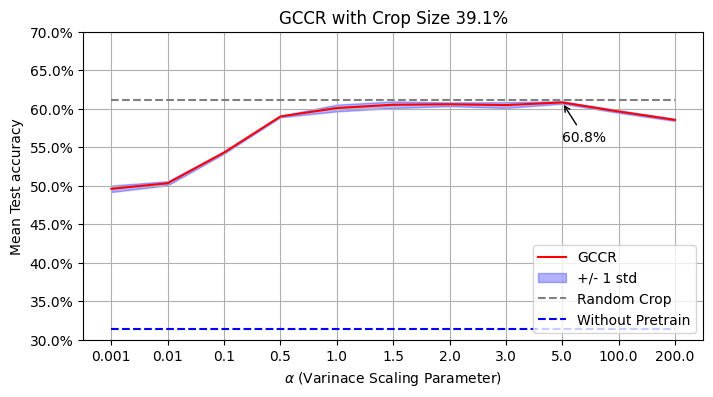

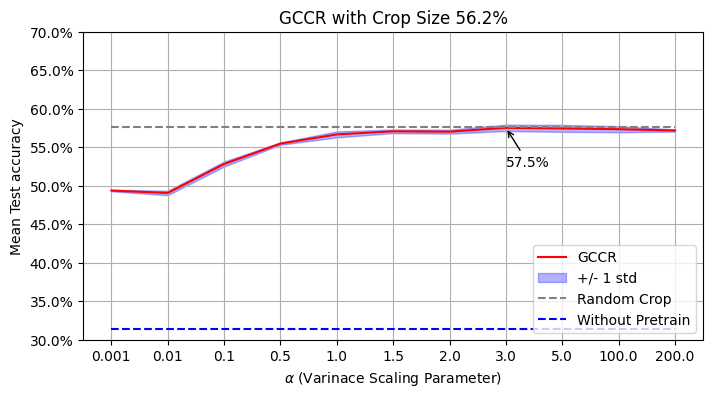

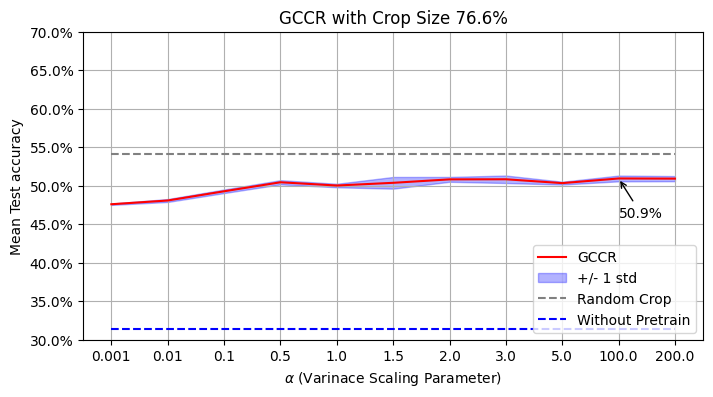

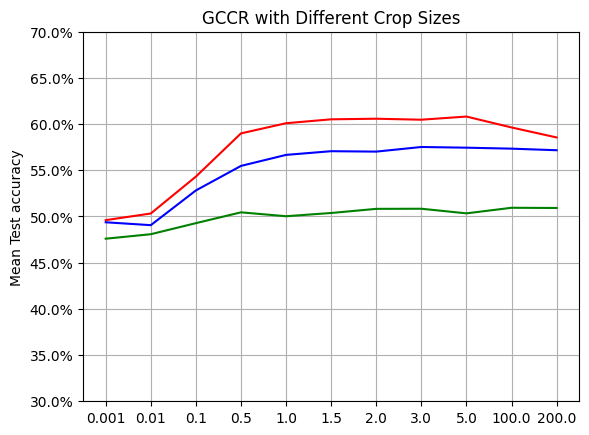

In [161]:
fig, df1 = visualize(gccr_results1)
x = df1['Std']
y1 = np.repeat(random_croping_df.loc['0.4']['test_mean'], len(x))
plt.plot(x, y1, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df2 = visualize(gccr_results2)
x = df2['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df3 = visualize(gccr_results3)
x = df3['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

plt.plot(df1['Std'], df1['test_mean'], c='red', alpha=1, label='0.4', )
plt.plot(df2['Std'], df2['test_mean'], c='blue', alpha=1, label='0.6', )
plt.plot(df3['Std'], df3['test_mean'], c='green', alpha=1, label='0.8', )
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim(0.3, 0.7)
plt.ylabel('Mean Test accuracy')
plt.title(f'GCCR with Different Crop Sizes')
fig.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
plt.grid()
plt.show()

In [162]:
gcc_results1 = {"results": {"gcc": {"0.4": {"0.001": [[0.4937, 0.4798, 0.512975], [0.4938, 0.4768, 0.51005], [0.4937, 0.4824, 0.51465], [0.4883, 0.4775, 0.511975]], "0.01": [[0.4943, 0.4938, 0.523025], [0.4917, 0.4878, 0.52655], [0.4913, 0.4878, 0.5229], [0.4941, 0.4844, 0.520275]], "0.1": [[0.5552, 0.5658, 0.61055], [0.5549, 0.5659, 0.606325], [0.554, 0.5657, 0.60745], [0.5576, 0.5776, 0.616]], "0.5": [[0.6021, 0.5962, 0.63885], [0.6001, 0.5839, 0.6321], [0.6052, 0.598, 0.64], [0.6007, 0.5966, 0.638025]], "1.0": [[0.6064, 0.6043, 0.637475], [0.6155, 0.605, 0.640225], [0.6073, 0.6051, 0.6398], [0.6075, 0.5994, 0.6359]], "1.5": [[0.6154, 0.6068, 0.643], [0.614, 0.6086, 0.6421], [0.6132, 0.6046, 0.6401], [0.6136, 0.6081, 0.638275]], "2.0": [[0.6199, 0.6102, 0.644075], [0.6171, 0.6055, 0.640675], [0.6171, 0.6078, 0.641525], [0.6153, 0.6164, 0.642125]], "3.0": [[0.6214, 0.6062, 0.636925], [0.6181, 0.603, 0.634875], [0.6138, 0.6038, 0.633975], [0.6186, 0.613, 0.637825]], "5.0": [[0.6038, 0.5948, 0.6179], [0.6143, 0.5979, 0.622775], [0.6113, 0.6011, 0.62745], [0.6111, 0.5943, 0.621025]], "100.0": [[0.4288, 0.4187, 0.4248], [0.4288, 0.4292, 0.429], [0.4302, 0.4184, 0.42515], [0.4306, 0.4302, 0.430975]], "200.0": [[0.4273, 0.4238, 0.41875], [0.4197, 0.4165, 0.414175], [0.4179, 0.4146, 0.414025], [0.4249, 0.4194, 0.417625]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162224", "method": ["gcc"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gcc_results2 = {"results": {"gcc": {"0.6": {"0.001": [[0.495, 0.4737, 0.516425], [0.49, 0.4725, 0.5126], [0.4918, 0.4709, 0.51135], [0.493, 0.4693, 0.51175]], "0.01": [[0.4978, 0.4817, 0.5319], [0.4989, 0.4835, 0.528175], [0.5024, 0.4816, 0.5279], [0.5047, 0.4888, 0.5324]], "0.1": [[0.5343, 0.5337, 0.585875], [0.5299, 0.5301, 0.593225], [0.539, 0.5417, 0.592225], [0.5317, 0.5352, 0.593225]], "0.5": [[0.5737, 0.5697, 0.6232], [0.5766, 0.5757, 0.628425], [0.5768, 0.572, 0.6267], [0.5775, 0.566, 0.62485]], "1.0": [[0.5948, 0.58, 0.63335], [0.5905, 0.5811, 0.631325], [0.5929, 0.5856, 0.63465], [0.5941, 0.5802, 0.6365]], "1.5": [[0.6031, 0.5863, 0.640725], [0.603, 0.584, 0.6358], [0.6084, 0.5859, 0.640125], [0.6057, 0.5861, 0.636525]], "2.0": [[0.6062, 0.5917, 0.6338], [0.6111, 0.5861, 0.63605], [0.6033, 0.5896, 0.634475], [0.6048, 0.5947, 0.634275]], "3.0": [[0.6056, 0.5862, 0.628925], [0.6063, 0.5856, 0.629825], [0.6075, 0.5787, 0.6253], [0.6087, 0.59, 0.630675]], "5.0": [[0.6031, 0.5845, 0.62045], [0.6065, 0.5824, 0.62265], [0.605, 0.5825, 0.6186], [0.6006, 0.5767, 0.614825]], "100.0": [[0.4262, 0.4119, 0.425725], [0.4277, 0.4183, 0.42655], [0.4192, 0.4179, 0.430575], [0.4308, 0.4147, 0.434175]], "200.0": [[0.4052, 0.3924, 0.402475], [0.4087, 0.3944, 0.409125], [0.4001, 0.3889, 0.4051], [0.4138, 0.4035, 0.41205]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162222", "method": ["gcc"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}
gcc_results3 = {"results": {"gcc": {"0.8": {"0.001": [[0.4709, 0.4606, 0.504175], [0.473, 0.4607, 0.5021], [0.4727, 0.4605, 0.501525], [0.4808, 0.4701, 0.501]], "0.01": [[0.481, 0.4738, 0.50965], [0.485, 0.4681, 0.509425], [0.4855, 0.468, 0.5072], [0.4842, 0.4674, 0.511375]], "0.1": [[0.5061, 0.4951, 0.55145], [0.5128, 0.498, 0.547275], [0.5099, 0.4945, 0.5515], [0.509, 0.4985, 0.5488]], "0.5": [[0.5361, 0.5225, 0.578225], [0.535, 0.5307, 0.5744], [0.5406, 0.5226, 0.58215], [0.537, 0.5259, 0.5812]], "1.0": [[0.5545, 0.534, 0.590925], [0.5499, 0.533, 0.588075], [0.547, 0.5354, 0.58595], [0.547, 0.5379, 0.589075]], "1.5": [[0.5622, 0.5448, 0.589725], [0.56, 0.5389, 0.5929], [0.5608, 0.5372, 0.5877], [0.5607, 0.542, 0.588]], "2.0": [[0.5627, 0.5521, 0.58925], [0.57, 0.5507, 0.595125], [0.5591, 0.5471, 0.59425], [0.5636, 0.5491, 0.5963]], "3.0": [[0.5661, 0.5466, 0.592875], [0.5652, 0.552, 0.5886], [0.5623, 0.5465, 0.590675], [0.5687, 0.5494, 0.58565]], "5.0": [[0.5642, 0.5508, 0.58265], [0.5518, 0.5471, 0.580025], [0.5588, 0.547, 0.57875], [0.5582, 0.5497, 0.582]], "100.0": [[0.4299, 0.4277, 0.442075], [0.4316, 0.4229, 0.43915], [0.4314, 0.43, 0.4408], [0.4285, 0.4287, 0.437225]], "200.0": [[0.4125, 0.4006, 0.41385], [0.4208, 0.4057, 0.4174], [0.4243, 0.4052, 0.422475], [0.4214, 0.4029, 0.418175]]}}}, "epoch": 150, "num_classes_workers": 4, "hidden_dim": 256, "batch_size": 512, "clf_epochs": 100, "Job_id": "162226", "method": ["gcc"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 100.0, 200.0], "num_of_trials": 4}

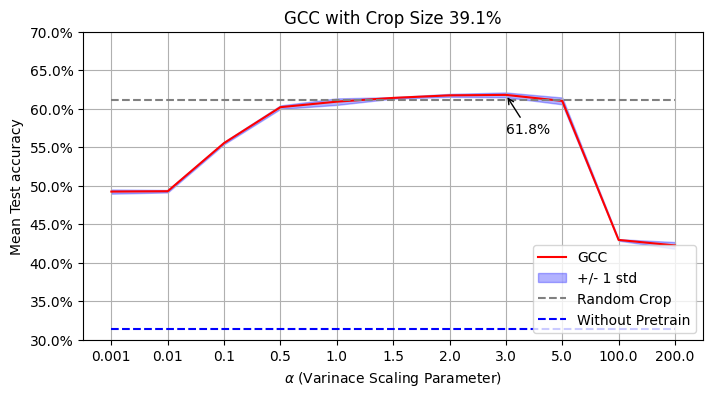

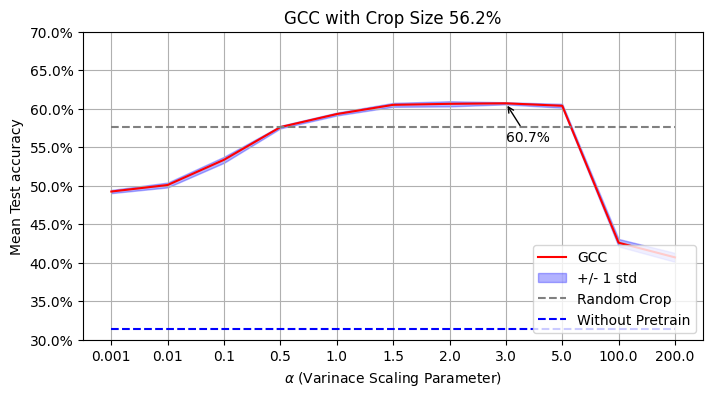

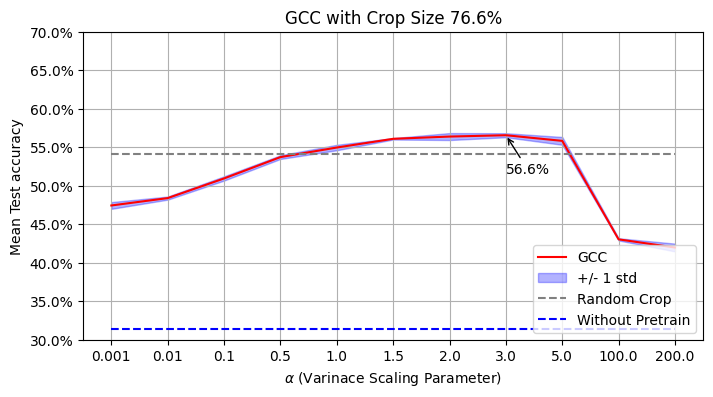

In [163]:
fig, df = visualize(gcc_results1)
x = df['Std']
y = np.repeat(random_croping_df.loc['0.4']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df = visualize(gcc_results2)
x = df['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()
fig, df = visualize(gcc_results3)
x = df['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

# NEW

# Crop Size 19.1%

In [164]:
gcc = {"results": {"gcc": {"0.2": {"0.001": [[0.4969, 0.4894, 0.51235], [0.4884, 0.4845, 0.505475], [0.5006, 0.5065, 0.516325], [0.4995, 0.4942, 0.516225]], "0.01": [[0.5061, 0.5105, 0.534425], [0.5102, 0.5093, 0.536425], [0.513, 0.521, 0.53555], [0.5055, 0.5093, 0.5315]], "0.1": [[0.5703, 0.5805, 0.597625], [0.5582, 0.5745, 0.591975], [0.5682, 0.5765, 0.599675], [0.5567, 0.5747, 0.594375]], "0.5": [[0.6277, 0.6407, 0.655825], [0.6225, 0.6359, 0.651875], [0.6268, 0.6354, 0.652], [0.6227, 0.643, 0.65395]], "1.0": [[0.668, 0.6672, 0.681575], [0.6566, 0.6614, 0.675675], [0.6574, 0.6575, 0.67425], [0.6549, 0.6612, 0.6723]], "1.5": [[0.6419, 0.6496, 0.66235], [0.6483, 0.6518, 0.66695], [0.6487, 0.652, 0.667475], [0.6508, 0.6555, 0.6687]], "2.0": [[0.6467, 0.6507, 0.668175], [0.649, 0.6505, 0.666775], [0.6444, 0.6563, 0.6643], [0.633, 0.6454, 0.663925]], "3.0": [[0.6287, 0.6389, 0.653025], [0.624, 0.6296, 0.644925], [0.631, 0.6362, 0.646625], [0.6186, 0.6256, 0.639675]], "4.0": [[0.6127, 0.6128, 0.6232], [0.6085, 0.6066, 0.624375], [0.605, 0.6076, 0.6253], [0.6088, 0.6085, 0.62245]], "5.0": [[0.5804, 0.5772, 0.592525], [0.5929, 0.5919, 0.6043], [0.5859, 0.5888, 0.60025], [0.5776, 0.5847, 0.594025]], "10.0": [[0.5095, 0.5044, 0.515975], [0.509, 0.5001, 0.5115], [0.4972, 0.5004, 0.510875], [0.5008, 0.5072, 0.519075]], "50.0": [[0.3442, 0.3295, 0.328825], [0.3382, 0.3321, 0.332425], [0.329, 0.3308, 0.328225], [0.3445, 0.3324, 0.326425]], "100.0": [[0.3149, 0.2945, 0.303575], [0.3148, 0.3029, 0.305325], [0.3296, 0.3161, 0.312525], [0.3253, 0.3132, 0.3117]], "200.0": [[0.3086, 0.2943, 0.294375], [0.2879, 0.277, 0.277275], [0.2911, 0.2709, 0.2684], [0.3106, 0.296, 0.287425]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625340", "method": ["gcc"], "crop_size": [0.2], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gccr = {"results": {"gccr": {"0.2": {"0.001": [[0.4801, 0.4863, 0.503975], [0.4888, 0.4789, 0.503025], [0.4825, 0.4809, 0.5058], [0.4821, 0.4867, 0.50375]], "0.01": [[0.5051, 0.5063, 0.528675], [0.512, 0.5186, 0.5354], [0.5064, 0.5117, 0.533025], [0.5156, 0.5106, 0.537825]], "0.1": [[0.5671, 0.5758, 0.59625], [0.5673, 0.5756, 0.597125], [0.5662, 0.5655, 0.595025], [0.5525, 0.5704, 0.59035]], "0.5": [[0.6135, 0.6375, 0.6515], [0.6195, 0.6358, 0.65275], [0.6077, 0.6341, 0.644], [0.6216, 0.6372, 0.6505]], "1.0": [[0.643, 0.6603, 0.665275], [0.6414, 0.6597, 0.6704], [0.6337, 0.6545, 0.661125], [0.6437, 0.6575, 0.666375]], "1.5": [[0.6388, 0.6519, 0.66355], [0.6425, 0.6633, 0.6708], [0.6481, 0.6691, 0.6747], [0.6445, 0.6543, 0.66925]], "2.0": [[0.6307, 0.6474, 0.6538], [0.6426, 0.6565, 0.668225], [0.6318, 0.6552, 0.65595], [0.6422, 0.6572, 0.667175]], "3.0": [[0.6444, 0.6465, 0.662075], [0.6385, 0.6551, 0.663], [0.6466, 0.6452, 0.662], [0.6391, 0.658, 0.6669]], "4.0": [[0.6255, 0.6441, 0.6532], [0.6258, 0.6373, 0.64845], [0.63, 0.646, 0.65285], [0.6376, 0.6419, 0.651675]], "5.0": [[0.6229, 0.6401, 0.643125], [0.6183, 0.6341, 0.642875], [0.6218, 0.6439, 0.64055], [0.6174, 0.6399, 0.64335]], "10.0": [[0.6156, 0.6251, 0.62055], [0.6053, 0.6199, 0.61955], [0.6149, 0.6261, 0.6293], [0.6143, 0.6207, 0.626775]], "50.0": [[0.5487, 0.5623, 0.56515], [0.5531, 0.5595, 0.569425], [0.5606, 0.5616, 0.56535], [0.5583, 0.5616, 0.567025]], "100.0": [[0.5386, 0.5437, 0.547025], [0.5456, 0.541, 0.5456], [0.5332, 0.5426, 0.54235], [0.5468, 0.5449, 0.5489]], "200.0": [[0.5261, 0.5206, 0.52405], [0.5165, 0.5133, 0.51555], [0.5176, 0.5199, 0.5214], [0.5309, 0.529, 0.52735]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625351", "method": ["gccr"], "crop_size": [0.2], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gcc_adp = {"results": {"gcc": {"0.2": {"0.001": [[0.5386, 0.5345, 0.54645], [0.5415, 0.5382, 0.54905], [0.538, 0.5326, 0.545225], [0.5395, 0.5342, 0.544025]], "0.01": [[0.5629, 0.5606, 0.580575], [0.5632, 0.561, 0.58005], [0.5686, 0.5708, 0.580525], [0.5637, 0.5631, 0.586625]], "0.1": [[0.5933, 0.6035, 0.6231], [0.5987, 0.6017, 0.625475], [0.595, 0.6019, 0.623075], [0.6045, 0.6086, 0.629175]], "0.5": [[0.642, 0.6486, 0.662975], [0.6375, 0.6392, 0.658475], [0.6418, 0.6433, 0.661225], [0.6371, 0.6403, 0.65905]], "1.0": [[0.6357, 0.6415, 0.65665], [0.6345, 0.637, 0.654525], [0.6391, 0.6327, 0.652875], [0.6347, 0.6417, 0.65545]], "1.5": [[0.6349, 0.636, 0.655625], [0.6441, 0.6408, 0.661475], [0.6447, 0.6442, 0.66435], [0.6355, 0.64, 0.656225]], "2.0": [[0.6248, 0.6331, 0.6525], [0.6245, 0.6274, 0.649075], [0.6291, 0.634, 0.652], [0.6299, 0.6393, 0.656025]], "3.0": [[0.6175, 0.6174, 0.631425], [0.6135, 0.6098, 0.63235], [0.6124, 0.6136, 0.6297], [0.6147, 0.6082, 0.62575]], "4.0": [[0.5935, 0.5974, 0.6132], [0.5888, 0.5824, 0.600325], [0.5952, 0.5939, 0.6106], [0.5969, 0.5981, 0.61225]], "5.0": [[0.5819, 0.5727, 0.58705], [0.5756, 0.5742, 0.58695], [0.5776, 0.5729, 0.587975], [0.5854, 0.5817, 0.593225]], "10.0": [[0.4846, 0.4817, 0.495175], [0.4953, 0.4902, 0.498075], [0.4832, 0.4826, 0.490925], [0.4906, 0.4844, 0.49605]], "50.0": [[0.2179, 0.2129, 0.258825], [0.3256, 0.3348, 0.331675], [0.2192, 0.2151, 0.245525], [0.3342, 0.3286, 0.3296]], "100.0": [[0.2015, 0.2044, 0.199375], [0.3211, 0.3074, 0.308425], [0.3161, 0.3084, 0.30425], [0.3219, 0.316, 0.31145]], "200.0": [[0.28, 0.2644, 0.27425], [0.2974, 0.2841, 0.28335], [0.3096, 0.2907, 0.292125], [0.3016, 0.2868, 0.28295]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625420", "method": ["gcc"], "crop_size": [0.2], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}
gccr_adp = {"results": {"gccr": {"0.2": {"0.001": [[0.5405, 0.5211, 0.5445], [0.5305, 0.5205, 0.5452], [0.5381, 0.5267, 0.55], [0.5312, 0.5168, 0.540225]], "0.01": [[0.5588, 0.5489, 0.57875], [0.56, 0.5463, 0.579625], [0.5514, 0.552, 0.575925], [0.554, 0.5493, 0.578575]], "0.1": [[0.5935, 0.5952, 0.624975], [0.588, 0.5915, 0.6251], [0.59, 0.5955, 0.624025], [0.5881, 0.5953, 0.6248]], "0.5": [[0.625, 0.6318, 0.657425], [0.6226, 0.6314, 0.6568], [0.6247, 0.6353, 0.65695], [0.6296, 0.6299, 0.6556]], "1.0": [[0.6267, 0.6327, 0.662375], [0.6307, 0.6406, 0.663075], [0.6345, 0.6396, 0.663325], [0.6322, 0.6433, 0.664175]], "1.5": [[0.6369, 0.6386, 0.659875], [0.6371, 0.6366, 0.664275], [0.6238, 0.6347, 0.65945], [0.638, 0.6387, 0.664825]], "2.0": [[0.6293, 0.6358, 0.6584], [0.6201, 0.6313, 0.6567], [0.6415, 0.6394, 0.66095], [0.6297, 0.6362, 0.657575]], "3.0": [[0.6174, 0.6267, 0.644275], [0.6388, 0.6407, 0.665525], [0.6226, 0.6341, 0.657325], [0.6335, 0.6371, 0.657725]], "4.0": [[0.6293, 0.6307, 0.652675], [0.6327, 0.6296, 0.64975], [0.6247, 0.623, 0.6504], [0.6269, 0.622, 0.648825]], "5.0": [[0.6173, 0.6203, 0.642225], [0.6205, 0.6253, 0.64145], [0.6118, 0.6136, 0.639675], [0.6077, 0.611, 0.635125]], "10.0": [[0.6033, 0.606, 0.621975], [0.5995, 0.6023, 0.623275], [0.6015, 0.6024, 0.620175], [0.6034, 0.6052, 0.626825]], "50.0": [[0.5623, 0.5559, 0.5681], [0.5503, 0.5549, 0.566325], [0.5563, 0.5561, 0.56875], [0.5599, 0.5605, 0.569125]], "100.0": [[0.5574, 0.5465, 0.55795], [0.5401, 0.531, 0.55255], [0.5463, 0.5435, 0.5554], [0.5468, 0.5376, 0.551125]], "200.0": [[0.5269, 0.5165, 0.526825], [0.5322, 0.5234, 0.529575], [0.5225, 0.505, 0.525275], [0.5217, 0.5215, 0.534075]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625431", "method": ["gccr"], "crop_size": [0.2], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}

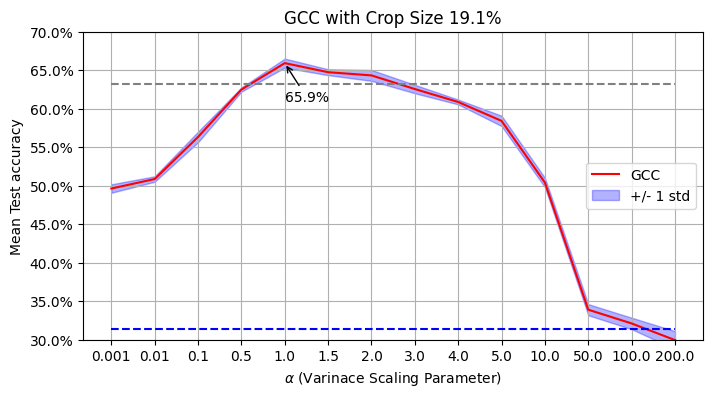

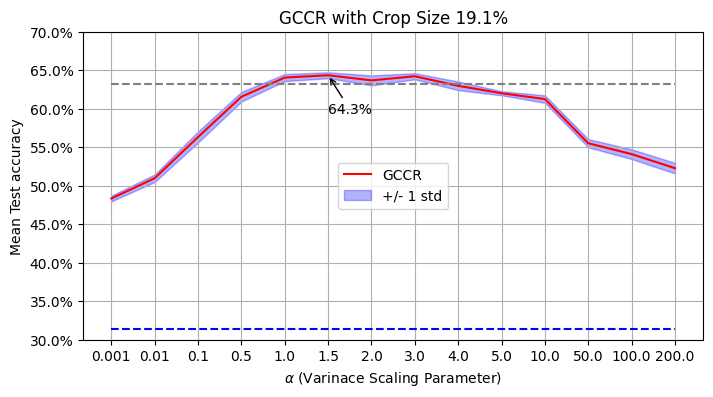

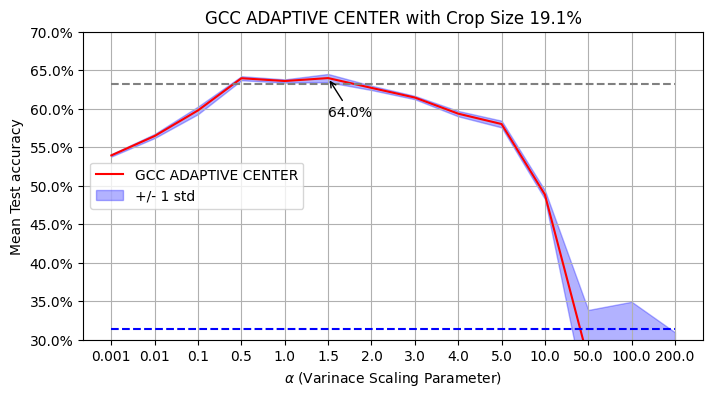

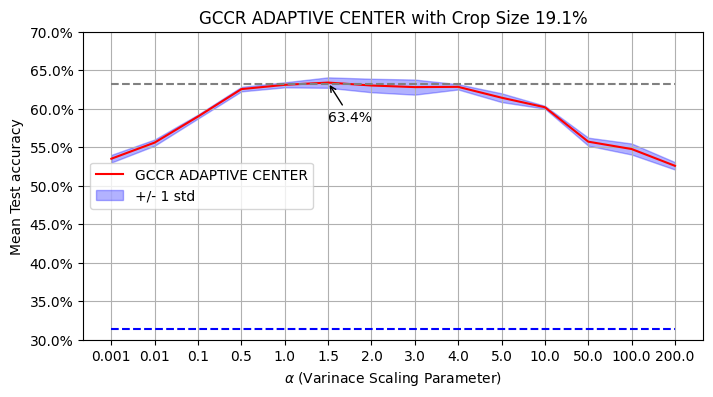

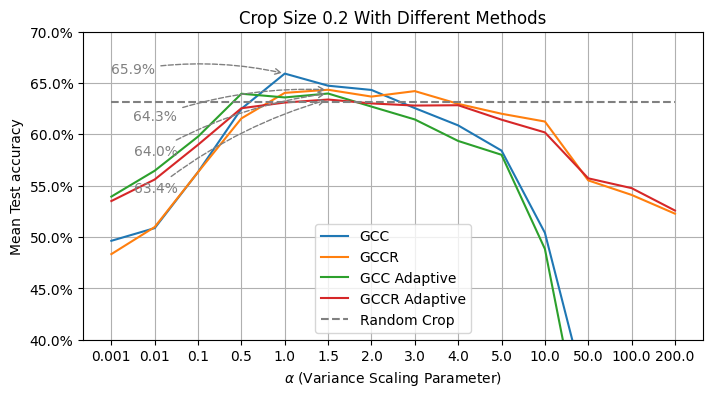

In [165]:
def plot_individual(fig, df, label, i, crop='0.2'):
    plt.plot(df['Std'], df['test_mean'], label=label)
    max_value = df['test_mean'].max()
    std_max = df[df['test_mean'] == max_value]['Std'].values[0]
    plt.annotate(f'{max_value:.1%}', xy=(std_max, max_value), xytext=(float(std_max)-1+0.01*i, max_value - 0.03*i),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1", color='gray', ls='--'), fontsize=10, color='gray')


def add_rc_and_wo(fig, df, crop='0.2'):
    random_crop_mean = random_croping_df.loc[crop]['test_mean']
    plt.plot(df['Std'], [random_crop_mean] * len(df), c='gray', linestyle='--', label='Random Crop')
    plt.plot(df['Std'], [without_pretrain_df.iloc[0]['test_mean']] * len(df), c='blue', linestyle='--', label='Without Pretrain')

crop = '0.2'    
fig, df1 = visualize(gcc)
add_rc_and_wo(fig, df1, crop)
fig, df2 = visualize(gccr)
add_rc_and_wo(fig, df2, crop)
fig, df3 = visualize(gcc_adp, adapt_center=True)
add_rc_and_wo(fig, df3, crop)
fig, df4 = visualize(gccr_adp, adapt_center=True)
add_rc_and_wo(fig, df4, crop)


plt.figure(figsize=(8, 4))
plot_individual(fig, df1, 'GCC', 0)
plot_individual(fig, df2, 'GCCR', 1)
plot_individual(fig, df3, 'GCC Adaptive', 2)
plot_individual(fig, df4, 'GCCR Adaptive', 3)
crop = '0.2'
random_crop_mean = random_croping_df.loc[crop]['test_mean']
plt.plot(df1['Std'], [random_crop_mean] * len(df1), c='gray', linestyle='--', label='Random Crop')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim(0.4, 0.7)
plt.ylabel('Mean Test accuracy')
plt.title(f'Crop Size {crop} With Different Methods')
plt.xlabel(r"$\alpha$ (Variance Scaling Parameter)")
plt.legend()
plt.grid()
plt.show()


# Crop Size 39.1%

In [166]:
gcc = {"results": {"gcc": {"0.4": {"0.001": [[0.5186, 0.5139, 0.5295], [0.4986, 0.4918, 0.50985], [0.5039, 0.4947, 0.5166], [0.5074, 0.5074, 0.52265]], "0.01": [[0.5335, 0.5285, 0.54085], [0.5325, 0.5391, 0.5479], [0.5204, 0.5245, 0.54275], [0.5254, 0.5286, 0.544475]], "0.1": [[0.587, 0.5871, 0.605825], [0.5823, 0.5944, 0.608375], [0.5898, 0.5891, 0.610475], [0.5869, 0.5912, 0.6052]], "0.5": [[0.6389, 0.6479, 0.6606], [0.6336, 0.6427, 0.658375], [0.6412, 0.6433, 0.662], [0.634, 0.6397, 0.6606]], "1.0": [[0.6685, 0.6776, 0.686225], [0.6638, 0.6687, 0.686825], [0.6678, 0.6667, 0.67995], [0.6728, 0.6754, 0.68805]], "1.5": [[0.6766, 0.6804, 0.69845], [0.6785, 0.6814, 0.696025], [0.6765, 0.6855, 0.69745], [0.6819, 0.687, 0.7016]], "2.0": [[0.6687, 0.6743, 0.683425], [0.6653, 0.6723, 0.6842], [0.6642, 0.666, 0.684775], [0.6626, 0.6775, 0.688175]], "3.0": [[0.6556, 0.654, 0.671125], [0.6563, 0.6602, 0.6726], [0.663, 0.6571, 0.67345], [0.6627, 0.6564, 0.66975]], "4.0": [[0.6272, 0.624, 0.6438], [0.6315, 0.6294, 0.645725], [0.6307, 0.6293, 0.6418], [0.6313, 0.6362, 0.64715]], "5.0": [[0.6175, 0.6128, 0.628375], [0.6175, 0.6158, 0.61955], [0.6167, 0.6117, 0.6262], [0.6128, 0.6149, 0.6248]], "10.0": [[0.5329, 0.5398, 0.5442], [0.5407, 0.5386, 0.554925], [0.5438, 0.5402, 0.551225], [0.5436, 0.5456, 0.54945]], "50.0": [[0.373, 0.3633, 0.362175], [0.3589, 0.357, 0.35445], [0.3639, 0.3673, 0.362225], [0.3574, 0.3608, 0.348325]], "100.0": [[0.3288, 0.3345, 0.3166], [0.3219, 0.323, 0.31375], [0.3245, 0.3299, 0.31565], [0.2669, 0.2356, 0.25305]], "200.0": [[0.3126, 0.2922, 0.2905], [0.334, 0.3223, 0.3114], [0.3155, 0.301, 0.297075], [0.308, 0.2974, 0.290375]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625362", "method": ["gcc"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gccr ={"results": {"gccr": {"0.4": {"0.001": [[0.5082, 0.5011, 0.5288], [0.5078, 0.5043, 0.527725], [0.519, 0.5081, 0.53325], [0.5236, 0.5055, 0.534125]], "0.01": [[0.524, 0.5205, 0.54865], [0.5309, 0.5186, 0.54705], [0.5113, 0.5107, 0.539375], [0.5242, 0.5202, 0.545375]], "0.1": [[0.5787, 0.5764, 0.6042], [0.5806, 0.5797, 0.60065], [0.5843, 0.5838, 0.610325], [0.5763, 0.5869, 0.606475]], "0.5": [[0.615, 0.6143, 0.635], [0.6143, 0.6141, 0.637175], [0.6057, 0.613, 0.6368], [0.6156, 0.6138, 0.64105]], "1.0": [[0.6155, 0.6201, 0.643725], [0.6188, 0.6228, 0.641125], [0.613, 0.6191, 0.639275], [0.6158, 0.6251, 0.64215]], "1.5": [[0.6245, 0.6286, 0.646925], [0.6178, 0.6107, 0.632025], [0.6186, 0.6217, 0.639425], [0.6224, 0.6239, 0.644775]], "2.0": [[0.6157, 0.6175, 0.640175], [0.6116, 0.6195, 0.63735], [0.6098, 0.6129, 0.629975], [0.6203, 0.6119, 0.636125]], "3.0": [[0.6124, 0.6094, 0.627525], [0.6101, 0.6097, 0.63245], [0.608, 0.6091, 0.631275], [0.6114, 0.6138, 0.629]], "4.0": [[0.6039, 0.6141, 0.625875], [0.5986, 0.6051, 0.6225], [0.6032, 0.6087, 0.627375], [0.6118, 0.6033, 0.624075]], "5.0": [[0.6102, 0.6096, 0.62725], [0.6021, 0.6105, 0.628225], [0.6039, 0.6079, 0.626025], [0.594, 0.6088, 0.620125]], "10.0": [[0.601, 0.6067, 0.61805], [0.5894, 0.5933, 0.613425], [0.5977, 0.6036, 0.6159], [0.5936, 0.5991, 0.6147]], "50.0": [[0.5762, 0.5844, 0.59645], [0.5758, 0.5834, 0.596125], [0.5702, 0.5744, 0.588775], [0.5785, 0.5851, 0.5959]], "100.0": [[0.5618, 0.5671, 0.57825], [0.5662, 0.5644, 0.5821], [0.5653, 0.5724, 0.58265], [0.5696, 0.5752, 0.58655]], "200.0": [[0.5578, 0.5644, 0.577425], [0.5594, 0.5635, 0.577775], [0.573, 0.5664, 0.579175], [0.5553, 0.5626, 0.574325]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625373", "method": ["gccr"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
#gcc_adp =...
gccr_adp ={"results": {"gccr": {"0.4": {"0.001": [[0.5179, 0.5053, 0.521425], [0.5165, 0.5027, 0.525425], [0.5186, 0.5149, 0.52445], [0.4912, 0.4871, 0.4983]], "0.01": [[0.5454, 0.5404, 0.558875], [0.551, 0.5488, 0.56885], [0.5534, 0.5478, 0.56495], [0.542, 0.5411, 0.5573]], "0.1": [[0.5956, 0.5981, 0.61835], [0.5951, 0.6035, 0.6221], [0.5902, 0.5909, 0.617875], [0.6008, 0.6066, 0.624225]], "0.5": [[0.6202, 0.6246, 0.644675], [0.6235, 0.6251, 0.6401], [0.6147, 0.6223, 0.640975], [0.6201, 0.6288, 0.64465]], "1.0": [[0.6155, 0.6275, 0.639325], [0.6126, 0.6217, 0.632575], [0.6107, 0.618, 0.634575], [0.6173, 0.6199, 0.636075]], "1.5": [[0.6113, 0.6193, 0.6291], [0.6051, 0.6141, 0.628875], [0.6106, 0.6156, 0.6268], [0.6202, 0.6199, 0.6308]], "2.0": [[0.6039, 0.6152, 0.62975], [0.6066, 0.6076, 0.626375], [0.6081, 0.6105, 0.629125], [0.5971, 0.6033, 0.620475]], "3.0": [[0.6018, 0.6152, 0.6266], [0.5979, 0.6094, 0.6206], [0.5961, 0.6126, 0.61935], [0.6065, 0.6099, 0.62685]], "4.0": [[0.602, 0.6088, 0.619775], [0.6008, 0.6046, 0.61955], [0.5979, 0.6075, 0.6202], [0.5961, 0.6121, 0.6197]], "5.0": [[0.5981, 0.6016, 0.621875], [0.6034, 0.6152, 0.621775], [0.5988, 0.6044, 0.616475], [0.6035, 0.6118, 0.623425]], "10.0": [[0.5859, 0.599, 0.609975], [0.585, 0.6014, 0.609125], [0.5916, 0.6008, 0.60765], [0.587, 0.5932, 0.6122]], "50.0": [[0.5747, 0.5804, 0.588775], [0.5728, 0.5775, 0.5953], [0.5683, 0.5758, 0.589775], [0.5702, 0.5757, 0.59]], "100.0": [[0.5794, 0.5751, 0.588725], [0.568, 0.576, 0.5849], [0.5689, 0.58, 0.5902], [0.5677, 0.581, 0.587425]], "200.0": [[0.5543, 0.563, 0.574], [0.5642, 0.5741, 0.5806], [0.5576, 0.5691, 0.57925], [0.5634, 0.5694, 0.57815]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625853", "method": ["gccr"], "crop_size": [0.4], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}

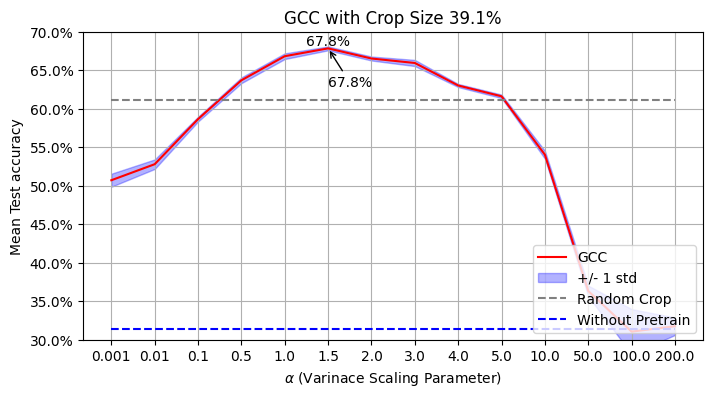

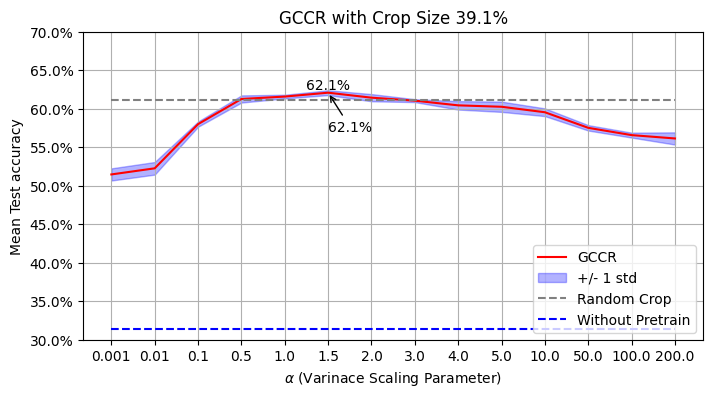

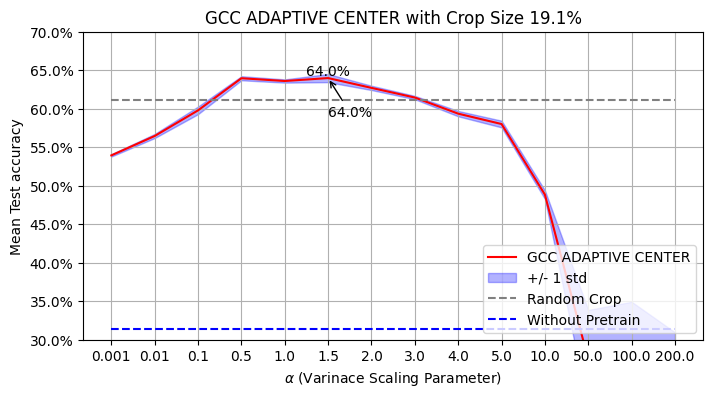

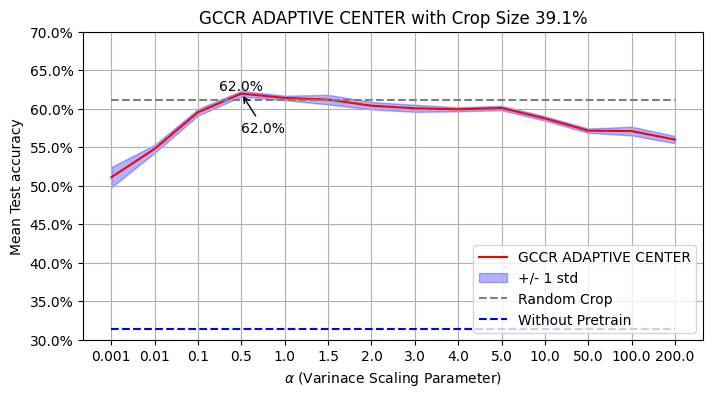

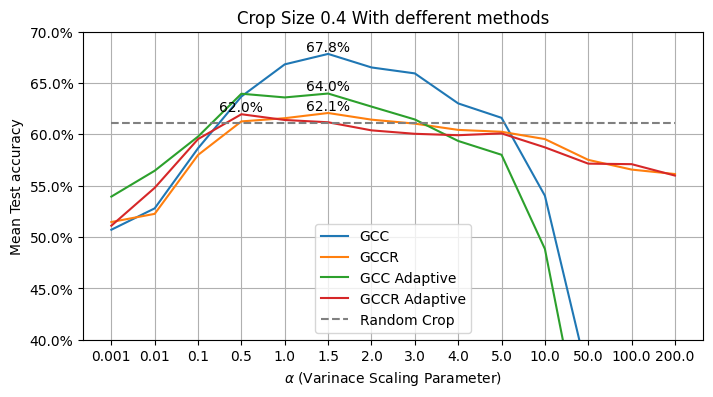

In [167]:
crop = '0.4'
fig, df1 = visualize(gcc)
x = df1['Std']
y = np.repeat(random_croping_df.loc[crop]['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
max = df1['test_mean'].max()
std_max = df1[df1['test_mean'] == max]['Std'].values[0]
plt.text(std_max, max, f'{max:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.legend(loc='lower right')
plt.show()

fig, df2 = visualize(gccr)
x = df2['Std']
y = np.repeat(random_croping_df.loc[crop]['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
max = df2['test_mean'].max()
std_max = df2[df2['test_mean'] == max]['Std'].values[0]
plt.text(std_max, max, f'{max:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.legend(loc='lower right')
plt.show()

fig, df3 = visualize(gcc_adp, adapt_center=True)
x = df3['Std']
y = np.repeat(random_croping_df.loc[crop]['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
max = df3['test_mean'].max()
std_max = df3[df3['test_mean'] == max]['Std'].values[0]
plt.text(std_max, max, f'{max:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.legend(loc='lower right')
plt.show()

fig, df4 = visualize(gccr_adp, adapt_center=True)
x = df4['Std']
y = np.repeat(random_croping_df.loc[crop]['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
max = df4['test_mean'].max()
std_max = df4[df4['test_mean'] == max]['Std'].values[0]
plt.text(std_max, max, f'{max:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize=(8, 4))
plt.plot(df1['Std'], df1['test_mean'], label='GCC')
plt.plot(df2['Std'], df2['test_mean'], label='GCCR')
plt.plot(df3['Std'], df3['test_mean'], label='GCC Adaptive')
plt.plot(df4['Std'], df4['test_mean'], label='GCCR Adaptive')
x = df4['Std']
y = np.repeat(random_croping_df.loc[crop]['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim(0.4, 0.7)
plt.ylabel('Mean Test accuracy')
plt.title(f'Crop Size {crop} With defferent methods') 
fig.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
max1 = df1['test_mean'].max()
std_max1 = df1[df1['test_mean'] == max1]['Std'].values[0]
max2 = df2['test_mean'].max()
std_max2 = df2[df2['test_mean'] == max2]['Std'].values[0]
max3 = df3['test_mean'].max()
std_max3 = df3[df3['test_mean'] == max3]['Std'].values[0]
max4 = df4['test_mean'].max()
std_max4 = df4[df4['test_mean'] == max4]['Std'].values[0]
plt.text(std_max1, max1, f'{max1:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.text(std_max2, max2, f'{max2:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.text(std_max3, max3, f'{max3:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.text(std_max4, max4, f'{max4:.1%}', fontsize=10, color='black', ha='center', va='bottom')
plt.legend()
plt.grid()
plt.show()

# Crop size 56.2

In [168]:
gcc = {"results": {"gcc": {"0.6": {"0.001": [[0.5164, 0.5072, 0.5316], [0.5032, 0.4951, 0.52305], [0.5011, 0.4844, 0.5138], [0.5079, 0.4914, 0.5132]], "0.01": [[0.5207, 0.5121, 0.535025], [0.5166, 0.5139, 0.541075], [0.518, 0.5127, 0.534625], [0.5161, 0.5163, 0.538675]], "0.1": [[0.5764, 0.5775, 0.5959], [0.5677, 0.5666, 0.5923], [0.5699, 0.5699, 0.591125], [0.5744, 0.5803, 0.595475]], "0.5": [[0.63, 0.6285, 0.64635], [0.6278, 0.6278, 0.644875], [0.6268, 0.6333, 0.645975], [0.6281, 0.6333, 0.646]], "1.0": [[0.6552, 0.6588, 0.67645], [0.6592, 0.6614, 0.6778], [0.655, 0.6627, 0.677225], [0.6569, 0.6617, 0.6779]], "1.5": [[0.6656, 0.6721, 0.692075], [0.6646, 0.6719, 0.690225], [0.6685, 0.6704, 0.6877], [0.6758, 0.6716, 0.69195]], "2.0": [[0.6713, 0.6723, 0.6912], [0.6699, 0.6744, 0.689675], [0.6721, 0.6726, 0.68745], [0.6711, 0.669, 0.6867]], "3.0": [[0.6506, 0.6589, 0.675525], [0.6517, 0.647, 0.67125], [0.6552, 0.6583, 0.67185], [0.6564, 0.6526, 0.674625]], "4.0": [[0.6435, 0.6366, 0.6546], [0.6366, 0.6432, 0.6553], [0.6342, 0.6389, 0.651825], [0.643, 0.6413, 0.659375]], "5.0": [[0.6232, 0.6281, 0.639775], [0.6152, 0.6251, 0.63915], [0.62, 0.6253, 0.637575], [0.6233, 0.628, 0.640775]], "10.0": [[0.5532, 0.5494, 0.564425], [0.5475, 0.5529, 0.566675], [0.5424, 0.5462, 0.567525], [0.5352, 0.5391, 0.5476]], "50.0": [[0.3779, 0.3706, 0.3774], [0.3813, 0.3772, 0.3782], [0.3802, 0.3671, 0.3771], [0.3801, 0.3749, 0.37885]], "100.0": [[0.3211, 0.3103, 0.31535], [0.3232, 0.3194, 0.3184], [0.3196, 0.3177, 0.3145], [0.3165, 0.308, 0.312125]], "200.0": [[0.3288, 0.3355, 0.32485], [0.3316, 0.3244, 0.319025], [0.3221, 0.3077, 0.30575], [0.3412, 0.3299, 0.327475]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625384", "method": ["gcc"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gccr = {"results": {"gccr": {"0.6": {"0.001": [[0.5027, 0.4884, 0.514425], [0.5041, 0.4931, 0.5197], [0.519, 0.4998, 0.53095], [0.5119, 0.4964, 0.5192]], "0.01": [[0.52, 0.5119, 0.544325], [0.5386, 0.5257, 0.5522], [0.513, 0.5062, 0.535425], [0.5144, 0.5044, 0.5325]], "0.1": [[0.5673, 0.5707, 0.59145], [0.5751, 0.5696, 0.606725], [0.5819, 0.5669, 0.600075], [0.5694, 0.5699, 0.5972]], "0.5": [[0.5814, 0.5748, 0.60325], [0.5902, 0.5715, 0.602], [0.5749, 0.575, 0.603925], [0.5848, 0.5744, 0.604675]], "1.0": [[0.586, 0.5781, 0.605975], [0.5779, 0.5715, 0.5977], [0.5791, 0.5679, 0.60445], [0.5818, 0.5753, 0.60315]], "1.5": [[0.5781, 0.5716, 0.5979], [0.5744, 0.57, 0.59715], [0.5768, 0.5698, 0.6001], [0.5786, 0.5767, 0.60255]], "2.0": [[0.576, 0.576, 0.6038], [0.5783, 0.574, 0.602625], [0.5762, 0.5736, 0.602825], [0.5759, 0.5728, 0.5992]], "3.0": [[0.5779, 0.5648, 0.5945], [0.578, 0.5728, 0.59825], [0.5725, 0.5705, 0.598475], [0.582, 0.5745, 0.60205]], "4.0": [[0.5752, 0.5675, 0.59335], [0.5759, 0.5655, 0.594625], [0.5781, 0.5718, 0.600675], [0.5837, 0.5751, 0.60095]], "5.0": [[0.5791, 0.5671, 0.59485], [0.5683, 0.5758, 0.594125], [0.5724, 0.5737, 0.5944], [0.57, 0.5639, 0.588075]], "10.0": [[0.5761, 0.5695, 0.589], [0.5597, 0.563, 0.581775], [0.5697, 0.5742, 0.59055], [0.577, 0.5709, 0.592625]], "50.0": [[0.5682, 0.554, 0.5813], [0.5694, 0.5568, 0.583375], [0.5619, 0.5626, 0.58025], [0.5646, 0.5626, 0.578475]], "100.0": [[0.557, 0.5563, 0.572225], [0.5551, 0.5513, 0.569725], [0.5543, 0.5539, 0.571275], [0.5665, 0.5579, 0.583275]], "200.0": [[0.5588, 0.5445, 0.568825], [0.5566, 0.5534, 0.567325], [0.5639, 0.5555, 0.57295], [0.5584, 0.5546, 0.5748]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625395", "method": ["gccr"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gcc_adp = {"results": {"gcc": {"0.6": {"0.001": [[0.5013, 0.4846, 0.505425], [0.5238, 0.5013, 0.53425], [0.4943, 0.4858, 0.504925], [0.5131, 0.4887, 0.51635]], "0.01": [[0.5597, 0.545, 0.56775], [0.5466, 0.5363, 0.564175], [0.5369, 0.5218, 0.555325], [0.5395, 0.5292, 0.552125]], "0.1": [[0.5983, 0.5868, 0.61995], [0.6046, 0.5984, 0.627725], [0.6034, 0.5963, 0.6216], [0.6024, 0.5961, 0.6283]], "0.5": [[0.6359, 0.6304, 0.6637], [0.6402, 0.635, 0.667975], [0.6383, 0.6404, 0.66485], [0.6399, 0.6363, 0.6638]], "1.0": [[0.6526, 0.6534, 0.680275], [0.6571, 0.6558, 0.682225], [0.6622, 0.6527, 0.68305], [0.6559, 0.6562, 0.6822]], "1.5": [[0.6506, 0.6453, 0.672475], [0.6601, 0.6518, 0.6781], [0.6587, 0.6554, 0.67885], [0.6573, 0.6555, 0.67955]], "2.0": [[0.6531, 0.648, 0.674825], [0.6535, 0.6494, 0.67075], [0.6606, 0.6532, 0.678225], [0.656, 0.6499, 0.67525]], "3.0": [[0.6342, 0.631, 0.654425], [0.643, 0.6321, 0.653925], [0.6532, 0.645, 0.66615], [0.6483, 0.6433, 0.658675]], "4.0": [[0.6275, 0.614, 0.641825], [0.6201, 0.6246, 0.64185], [0.6273, 0.6159, 0.637975], [0.6314, 0.6225, 0.644375]], "5.0": [[0.6038, 0.6019, 0.624425], [0.6089, 0.6044, 0.626425], [0.6114, 0.6075, 0.62585], [0.6015, 0.6016, 0.623975]], "10.0": [[0.541, 0.5329, 0.554275], [0.5474, 0.5349, 0.556725], [0.5387, 0.5501, 0.568575], [0.5489, 0.5501, 0.5673]], "50.0": [[0.377, 0.3698, 0.374], [0.3795, 0.3676, 0.373525], [0.3775, 0.3668, 0.37355], [0.3829, 0.3639, 0.376675]], "100.0": [[0.3276, 0.3166, 0.32295], [0.3256, 0.318, 0.3196], [0.3339, 0.3236, 0.33005], [0.3251, 0.3142, 0.319675]], "200.0": [[0.3281, 0.313, 0.321775], [0.3312, 0.32, 0.321275], [0.3286, 0.313, 0.323], [0.3255, 0.3132, 0.317375]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625864", "method": ["gcc"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}
gccr_adp = {"results": {"gccr": {"0.6": {"0.001": [[0.4842, 0.4822, 0.493175], [0.4731, 0.4625, 0.484925], [0.4814, 0.4837, 0.495975], [0.4746, 0.474, 0.48715]], "0.01": [[0.5226, 0.5232, 0.540125], [0.5407, 0.5419, 0.55575], [0.5183, 0.5259, 0.5383], [0.5296, 0.5325, 0.54255]], "0.1": [[0.585, 0.5859, 0.605775], [0.5797, 0.5845, 0.604675], [0.5801, 0.5835, 0.601775], [0.5759, 0.5791, 0.598275]], "0.5": [[0.589, 0.5917, 0.6114], [0.5949, 0.6006, 0.61595], [0.5987, 0.606, 0.62035], [0.595, 0.599, 0.6149]], "1.0": [[0.5813, 0.5882, 0.610425], [0.5832, 0.5911, 0.6038], [0.582, 0.5839, 0.603], [0.5896, 0.5858, 0.606275]], "1.5": [[0.585, 0.5916, 0.603075], [0.5845, 0.5845, 0.603775], [0.5852, 0.5803, 0.603325], [0.5639, 0.5783, 0.593375]], "2.0": [[0.5846, 0.5895, 0.602775], [0.5756, 0.5842, 0.60155], [0.5836, 0.5875, 0.6028], [0.581, 0.5901, 0.599725]], "3.0": [[0.5783, 0.584, 0.60025], [0.5687, 0.5758, 0.592], [0.5756, 0.5849, 0.596475], [0.5754, 0.5828, 0.596975]], "4.0": [[0.5881, 0.5869, 0.600325], [0.5777, 0.5745, 0.594925], [0.5792, 0.579, 0.59745], [0.5816, 0.5842, 0.5982]], "5.0": [[0.5743, 0.5856, 0.5995], [0.5798, 0.5837, 0.596375], [0.5869, 0.5898, 0.599575], [0.5748, 0.577, 0.590475]], "10.0": [[0.5749, 0.5829, 0.600425], [0.5688, 0.5718, 0.590275], [0.5746, 0.5762, 0.595825], [0.5754, 0.575, 0.592]], "50.0": [[0.5656, 0.5758, 0.58425], [0.5692, 0.5732, 0.588675], [0.5661, 0.5755, 0.5859], [0.5719, 0.5755, 0.586525]], "100.0": [[0.5555, 0.5556, 0.576175], [0.5592, 0.5686, 0.5722], [0.5575, 0.5684, 0.574425], [0.556, 0.5609, 0.570725]], "200.0": [[0.5522, 0.5595, 0.568725], [0.5608, 0.5678, 0.573875], [0.5557, 0.5657, 0.571475], [0.561, 0.5675, 0.572575]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625875", "method": ["gccr"], "crop_size": [0.6], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": True}

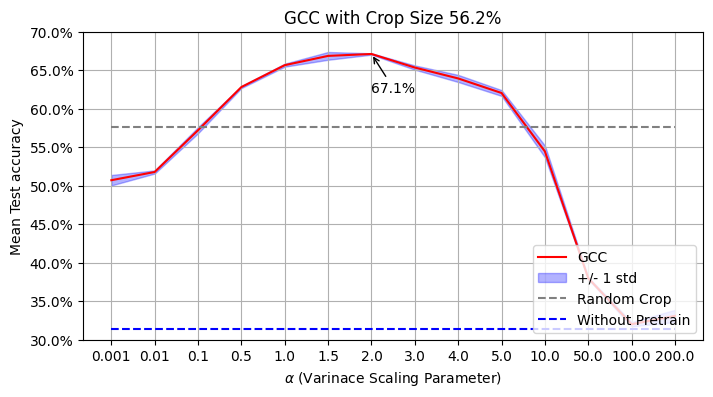

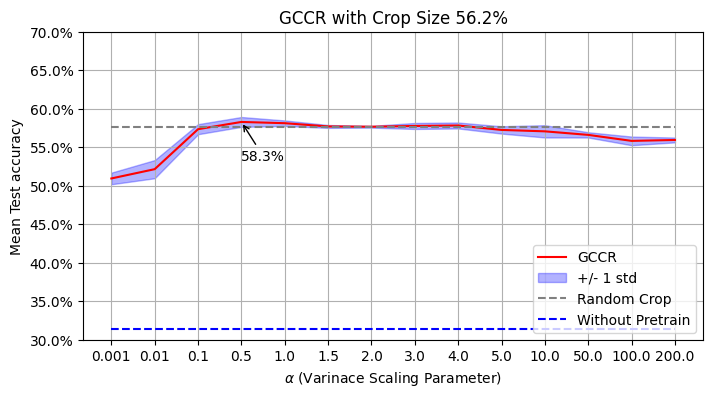

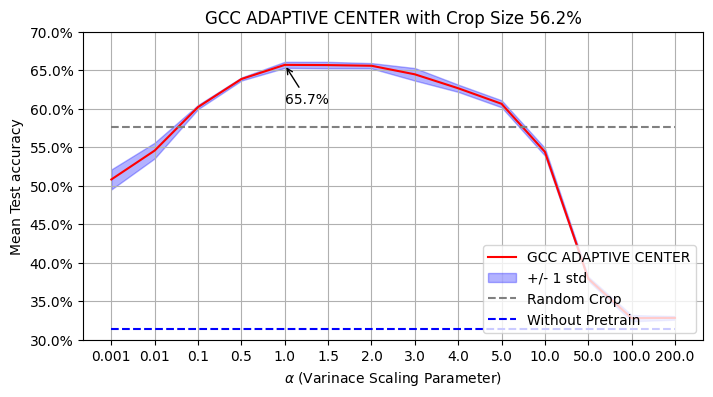

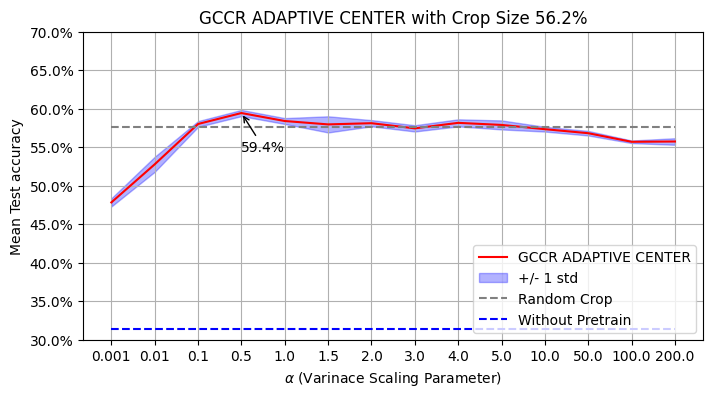

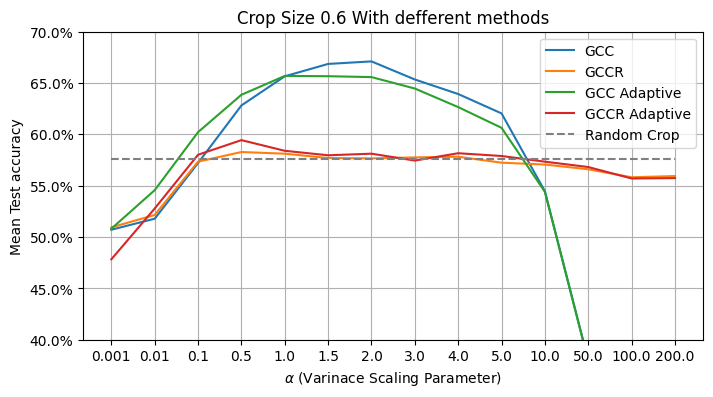

In [169]:
fig, df1 = visualize(gcc)
x = df1['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df2 = visualize(gccr)
x = df2['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df3 = visualize(gcc_adp, adapt_center=True)
x = df3['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df4 = visualize(gccr_adp, adapt_center=True)
x = df4['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize=(8, 4))
plt.plot(df1['Std'], df1['test_mean'], label='GCC')
plt.plot(df2['Std'], df2['test_mean'], label='GCCR')
plt.plot(df3['Std'], df3['test_mean'], label='GCC Adaptive')
plt.plot(df4['Std'], df4['test_mean'], label='GCCR Adaptive')
x = df4['Std']
y = np.repeat(random_croping_df.loc['0.6']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim(0.4, 0.7)
plt.ylabel('Mean Test accuracy')
plt.title(f'Crop Size 0.6 With defferent methods') 
fig.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
plt.legend()
plt.grid()
plt.show()

# Crop size 76.6

In [170]:
gcc = {"results": {"gcc": {"0.8": {"0.001": [[0.4842, 0.4778, 0.50005], [0.4971, 0.4795, 0.50565], [0.5025, 0.4883, 0.511175], [0.4892, 0.483, 0.5125]], "0.01": [[0.5084, 0.5017, 0.526225], [0.5115, 0.4982, 0.5282], [0.5097, 0.5062, 0.53095], [0.5118, 0.5123, 0.536125]], "0.1": [[0.5445, 0.5417, 0.56985], [0.5539, 0.5509, 0.574825], [0.5447, 0.5486, 0.56815], [0.5563, 0.554, 0.575975]], "0.5": [[0.6098, 0.5993, 0.6286], [0.6146, 0.6131, 0.6331], [0.6061, 0.6014, 0.622475], [0.6063, 0.6051, 0.625675]], "1.0": [[0.6469, 0.6397, 0.66445], [0.6361, 0.644, 0.660025], [0.6434, 0.6401, 0.65995], [0.643, 0.646, 0.662325]], "1.5": [[0.6536, 0.6529, 0.675775], [0.6614, 0.66, 0.678075], [0.6576, 0.6557, 0.675975], [0.6544, 0.6563, 0.673025]], "2.0": [[0.6645, 0.6606, 0.67985], [0.6683, 0.6588, 0.68155], [0.6645, 0.663, 0.685125], [0.6684, 0.6678, 0.6818]], "3.0": [[0.6523, 0.6503, 0.66845], [0.6446, 0.6455, 0.6606], [0.6483, 0.6436, 0.6637], [0.6605, 0.6512, 0.67395]], "4.0": [[0.6427, 0.6292, 0.651675], [0.6332, 0.6275, 0.647275], [0.6294, 0.6294, 0.644425], [0.6345, 0.6326, 0.648575]], "5.0": [[0.6184, 0.6159, 0.6332], [0.6211, 0.614, 0.634175], [0.6234, 0.6198, 0.63885], [0.6216, 0.6134, 0.635575]], "10.0": [[0.5637, 0.5543, 0.567525], [0.5494, 0.5547, 0.564075], [0.566, 0.5508, 0.573825], [0.5643, 0.5564, 0.571875]], "50.0": [[0.4019, 0.3881, 0.3933], [0.3787, 0.3654, 0.37455], [0.3846, 0.377, 0.385775], [0.3939, 0.3811, 0.383175]], "100.0": [[0.3439, 0.3295, 0.33725], [0.3481, 0.3298, 0.3333], [0.3338, 0.3251, 0.324125], [0.3458, 0.3357, 0.3378]], "200.0": [[0.2567, 0.2427, 0.24395], [0.3309, 0.3245, 0.33], [0.3218, 0.3045, 0.3158], [0.3202, 0.3138, 0.31235]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625406", "method": ["gcc"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gccr = {"results": {"gccr": {"0.8": {"0.001": [[0.4974, 0.4835, 0.5168], [0.4978, 0.4879, 0.50835], [0.5007, 0.4924, 0.512775], [0.4771, 0.4784, 0.500325]], "0.01": [[0.5118, 0.5109, 0.52825], [0.513, 0.4974, 0.525275], [0.5194, 0.505, 0.53685], [0.5142, 0.5082, 0.5355]], "0.1": [[0.5353, 0.5334, 0.56615], [0.5419, 0.5259, 0.558875], [0.541, 0.532, 0.557775], [0.5392, 0.5297, 0.565025]], "0.5": [[0.5464, 0.5411, 0.56645], [0.544, 0.5369, 0.565], [0.547, 0.5405, 0.569625], [0.5476, 0.5441, 0.5681]], "1.0": [[0.5491, 0.5236, 0.558825], [0.5478, 0.5452, 0.569625], [0.5421, 0.533, 0.56485], [0.54, 0.5388, 0.5656]], "1.5": [[0.5438, 0.5403, 0.56975], [0.545, 0.5437, 0.5654], [0.5471, 0.5519, 0.5762], [0.5485, 0.5387, 0.56395]], "2.0": [[0.5484, 0.5481, 0.574825], [0.5441, 0.5355, 0.5686], [0.5444, 0.5391, 0.57185], [0.542, 0.5361, 0.5688]], "3.0": [[0.5502, 0.5428, 0.566], [0.5442, 0.5419, 0.57275], [0.5431, 0.5355, 0.565425], [0.5507, 0.5451, 0.573575]], "4.0": [[0.5321, 0.5347, 0.560425], [0.5432, 0.5361, 0.562525], [0.5408, 0.5318, 0.565875], [0.5489, 0.536, 0.569925]], "5.0": [[0.5349, 0.5292, 0.5547], [0.5345, 0.5377, 0.5635], [0.5336, 0.5269, 0.557225], [0.5445, 0.5342, 0.56865]], "10.0": [[0.5503, 0.5381, 0.5691], [0.5476, 0.5356, 0.56605], [0.5524, 0.5363, 0.564325], [0.5417, 0.5383, 0.562925]], "50.0": [[0.547, 0.5463, 0.5677], [0.5462, 0.5321, 0.5673], [0.5406, 0.5298, 0.559075], [0.5423, 0.5403, 0.562825]], "100.0": [[0.5334, 0.5294, 0.5631], [0.542, 0.538, 0.563375], [0.5387, 0.5407, 0.56705], [0.534, 0.532, 0.561075]], "200.0": [[0.5454, 0.5342, 0.562525], [0.5489, 0.5388, 0.567325], [0.5425, 0.5303, 0.56345], [0.5486, 0.5336, 0.56565]]}}}, "epoch": 200, "num_classes_workers": 4, "hidden_dim": 128, "batch_size": 512, "clf_epochs": 100, "Job_id": "1625337", "method": ["gccr"], "crop_size": [0.8], "std": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 50.0, 100.0, 200.0], "num_of_trials": 4, "dataset": "TwoViewCifar10", "model": "Proto18", "adaptive_center": False}
gcc_adp =...
gccr_adp =...

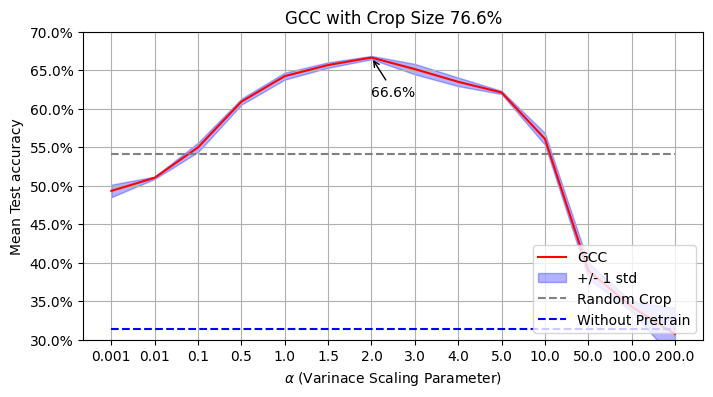

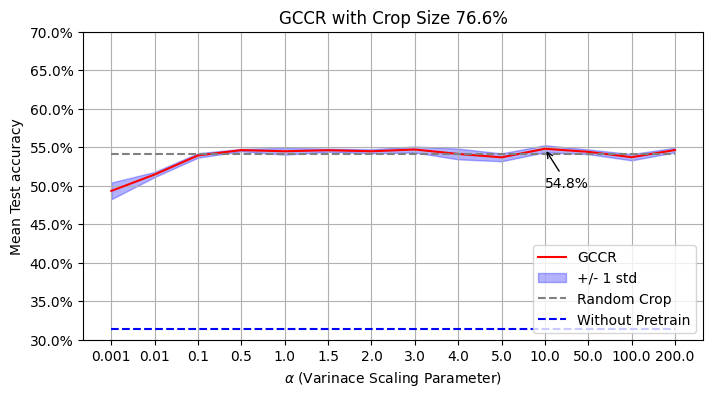

TypeError: 'ellipsis' object is not subscriptable

In [171]:
fig, df1 = visualize(gcc)
x = df1['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df2 = visualize(gccr)
x = df2['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df3 = visualize(gcc_adp, adapt_center=True)
x = df3['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig, df4 = visualize(gccr_adp, adapt_center=True)
x = df4['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
y2 = np.repeat(without_pretrain_df.iloc[0]['test_mean'], len(x))
plt.plot(x, y2, c='blue', linestyle='--', label='Without Pretrain')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize=(8, 4))
plt.plot(df1['Std'], df1['test_mean'], label='GCC')
plt.plot(df2['Std'], df2['test_mean'], label='GCCR')
plt.plot(df3['Std'], df3['test_mean'], label='GCC Adaptive')
plt.plot(df4['Std'], df4['test_mean'], label='GCCR Adaptive')
x = df4['Std']
y = np.repeat(random_croping_df.loc['0.8']['test_mean'], len(x))
plt.plot(x, y, c='gray', linestyle='--', label='Random Crop')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylim(0.4, 0.7)
plt.ylabel('Mean Test accuracy')
plt.title(f'Crop Size 0.4 With defferent methods') 
fig.gca().set_xlabel(r"$\alpha$ (Varinace Scaling Parameter)")
plt.legend()
plt.grid()
plt.show()